# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import folium
import h3
import geopandas as gpd
import geojson
from shapely.geometry import Point
import ast

In [2]:
df = pd.read_csv(
    "../data/analytics_trip_data.csv",
    index_col=None,
    dtype={
        'payment_type': 'category',
        'company': 'category'
    },     
    parse_dates=['trip_start_timestamp','trip_middle_timestamp','trip_end_timestamp'])

In [3]:
pd.set_option('display.max_columns', None)
df.describe()

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,trip_middle_timestamp,price_per_mile,miles_per_hour,temperature,precipitation
count,14562028,14562028,1.456203e+07,1.456203e+07,1.456203e+07,1.456203e+07,1.456157e+07,1.450446e+07,1.456203e+07,1.456203e+07,11550213.0,1.456203e+07,1.456203e+07,14562028,1.456160e+07,1.456203e+07,1.456203e+07,1.456203e+07
mean,2018-06-26 19:03:04.683017984,2018-06-26 19:17:55.079018240,8.885241e+02,4.092234e+00,1.703138e+10,1.703134e+10,2.536240e+01,2.222967e+01,1.425125e+01,1.844400e+00,0.0,8.380897e-01,1.707727e+01,2018-06-26 19:10:29.881018368,1.460164e+01,1.377499e+01,1.209902e+01,2.732992e-03
min,2018-01-01 00:15:00,2018-01-01 00:15:00,6.100000e+01,1.600000e-01,1.703101e+10,1.703101e+10,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,2018-01-01 00:15:00,1.000000e-02,1.000215e+00,-2.277778e+01,0.000000e+00
25%,2018-04-01 00:30:00,2018-04-01 00:45:00,4.030000e+02,1.000000e+00,1.703108e+10,1.703108e+10,8.000000e+00,8.000000e+00,6.500000e+00,0.000000e+00,0.0,0.000000e+00,7.750000e+00,2018-04-01 00:37:30,7.000000e+00,8.250000e+00,2.222222e+00,0.000000e+00
50%,2018-06-20 20:30:00,2018-06-20 20:45:00,6.030000e+02,1.700000e+00,1.703128e+10,1.703124e+10,2.800000e+01,2.400000e+01,8.500000e+00,0.000000e+00,0.0,0.000000e+00,1.050000e+01,2018-06-20 20:37:30,9.000000e+00,1.109589e+01,1.055556e+01,0.000000e+00
75%,2018-09-22 21:00:00,2018-09-22 21:15:00,1.026000e+03,4.000000e+00,1.703183e+10,1.703183e+10,3.200000e+01,3.200000e+01,1.500000e+01,2.400000e+00,0.0,1.000000e+00,1.725000e+01,2018-09-22 21:07:30,1.500000e+01,1.666667e+01,2.277778e+01,0.000000e+00
max,2018-12-30 23:45:00,2018-12-31 01:30:00,7.199000e+03,4.993000e+01,1.703198e+10,1.703198e+10,7.700000e+01,7.700000e+01,9.250000e+03,8.000000e+02,0.0,9.832430e+03,9.871430e+03,2018-12-31 00:30:00,1.333757e+04,5.000000e+01,3.555556e+01,1.100000e+00
std,NaN,NaN,7.941427e+02,5.353668e+00,3.389367e+05,3.220047e+05,1.981870e+01,1.724037e+01,1.988032e+01,2.895430e+00,0.0,9.218098e+00,2.370150e+01,NaN,2.145791e+01,8.358539e+00,1.179423e+01,2.687785e-02


In [4]:
# Extract day of the week, hour, and month from the timestamp
df['day_of_week'] = df['trip_start_timestamp'].dt.dayofweek
df['day_name'] = df['trip_start_timestamp'].dt.day_name()
df['hour'] = df['trip_start_timestamp'].dt.hour
df['month'] = df['trip_start_timestamp'].dt.month
df['month_name'] = df['trip_start_timestamp'].dt.month_name()
df['date'] = df['trip_start_timestamp'].dt.date
df['trip_minutes'] = df['trip_seconds'] / 60

In [5]:
df.head()

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_location,dropoff_centroid_location,h3_res_4_pickup,h3_res_6_pickup,h3_res_7_pickup,h3_res_8_pickup,h3_res_9_pickup,h3_res_4_dropoff,h3_res_6_dropoff,h3_res_7_dropoff,h3_res_8_dropoff,h3_res_9_dropoff,trip_middle_timestamp,price_per_mile,miles_per_hour,date,temperature,precipitation,day_of_week,day_name,hour,month,month_name,trip_minutes
0,ac1fae1544d7804f13fbf657cb058ba91a983fea,847cf962bd6f62040673e6c24c24940aeb2d7fdaa54677...,2018-01-01 00:15:00,2018-01-01 00:30:00,960.0,2.6,17031071500,17031080100,7.0,8.0,11.00,0.0,0.0,0.0,11.00,Cash,Taxi Affiliation Services,POINT (-87.6317173661 41.9146162864),POINT (-87.6266589003 41.90752007470001),842664dffffffff,862664c17ffffff,872664c11ffffff,882664c115fffff,892664c114fffff,842664dffffffff,862664c17ffffff,872664c11ffffff,882664c117fffff,892664c116fffff,2018-01-01 00:22:30,11.000000,9.750000,2018-01-01,-18.333333,0.0,0,Monday,0,1,January,16.000000
1,31c416218f80ee2e585777bb475243b971504afc,034ec4437f304cffcd4acf850106574343e69d3c5424ac...,2018-01-01 00:15:00,2018-01-01 00:30:00,523.0,2.6,17031030500,17031140602,77.0,14.0,9.75,2.0,NaN,0.0,11.75,Credit Card,Flash Cab,POINT (-87.6634164054 41.9867117999),POINT (-87.7215590627 41.968069),842664dffffffff,862664d8fffffff,872664d88ffffff,882664d88bfffff,892664d88bbffff,842664dffffffff,862664ca7ffffff,872664d99ffffff,882664d993fffff,892664d9937ffff,2018-01-01 00:22:30,9.750000,17.896750,2018-01-01,-18.333333,0.0,0,Monday,0,1,January,8.716667
2,b0a993338c200b1a3fea0d5602717c61c6b09eef,196d444ac93f57f7f4d7f4dde1753987581e0917e5f4e0...,2018-01-01 00:15:00,2018-01-01 00:30:00,308.0,1.3,17031062200,17031071100,6.0,7.0,6.25,2.0,NaN,0.0,8.25,Credit Card,Flash Cab,POINT (-87.6559981815 41.9442266014),POINT (-87.6494887289 41.9226862843),842664dffffffff,862664c17ffffff,872664c16ffffff,882664c163fffff,892664c1607ffff,842664dffffffff,862664c17ffffff,872664c13ffffff,882664c107fffff,892664c13d3ffff,2018-01-01 00:22:30,6.250000,15.194805,2018-01-01,-18.333333,0.0,0,Monday,0,1,January,5.133333
3,f93672d654d2821cfcc49150ff961a8fe281e61d,4563c3624d5325c354809e64158cc6d81e8f2254128a84...,2018-01-01 00:15:00,2018-01-01 00:15:00,381.0,1.3,17031081600,17031839000,8.0,32.0,6.75,3.0,NaN,0.0,9.75,Credit Card,Flash Cab,POINT (-87.6288741572 41.8920726347),POINT (-87.6314065252 41.8710158803),842664dffffffff,862664c1fffffff,872664c1effffff,882664c1e1fffff,892664c1e0fffff,842664dffffffff,862664c1fffffff,872664c1affffff,882664c1a3fffff,892664c1a07ffff,2018-01-01 00:15:00,6.750000,12.283465,2018-01-01,-18.333333,0.0,0,Monday,0,1,January,6.350000
4,1ffa4782096d433dc69fccbbc84326c442644e73,97ef85617790d7002c54286661e8d65eb3fe172022c50d...,2018-01-01 00:15:00,2018-01-01 00:15:00,403.0,0.9,17031081403,17031320100,8.0,32.0,6.25,2.0,NaN,1.0,9.25,Credit Card,Flash Cab,POINT (-87.6188683546 41.8909220259),POINT (-87.6209929134 41.8849871918),842664dffffffff,862664c1fffffff,872664c1effffff,882664c1e3fffff,892664c1e33ffff,842664dffffffff,862664c1fffffff,872664c1effffff,882664c1e3fffff,892664c1e2fffff,2018-01-01 00:15:00,7.361111,8.039702,2018-01-01,-18.333333,0.0,0,Monday,0,1,January,6.716667


# Basic exploration

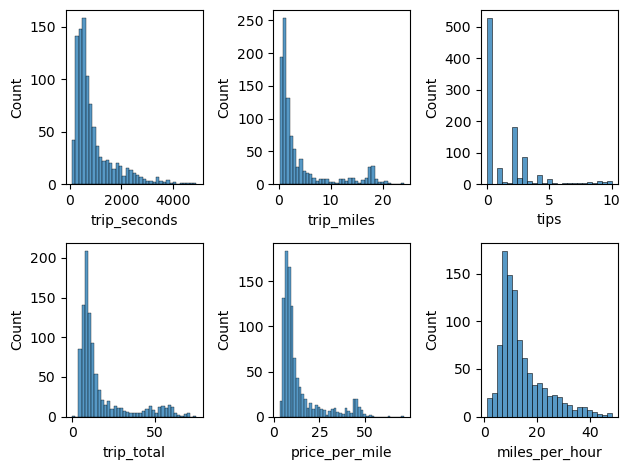

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=3)
axes = axes.flatten()

sns.histplot(df[df['trip_seconds'] <= 5000]["trip_seconds"].sample(1000), ax=axes[0])
sns.histplot(df[df["trip_miles"] <= 25]["trip_miles"].sample(1000), ax=axes[1])
sns.histplot(df[df["tips"] <= 10]["tips"].sample(1000), ax=axes[2])
sns.histplot(df[df["trip_total"] <= 75]["trip_total"].sample(1000), ax=axes[3])
sns.histplot(df[df["price_per_mile"] <= 75]["price_per_mile"].sample(1000), ax=axes[4])
sns.histplot(df[df["miles_per_hour"] <= 50]["miles_per_hour"].sample(1000), ax=axes[5])

plt.tight_layout()
plt.show()

## Companies

In [7]:
df['company'].value_counts()

company
Flash Cab                                    2198187
Chicago Carriage Cab Corp                    1960131
Taxi Affiliation Services                    1191286
Medallion Leasin                             1156303
City Service                                 1068156
                                              ...   
3669 - 85800 Jordan Taxi Inc                     347
2241 - 44667 - Felman Corp, Manuel Alonso         68
6057 - 24657 Richard Addo                         52
Metro Group                                        8
2809 - 95474 C & D Cab Co Inc.                     6
Name: count, Length: 69, dtype: int64

# Maps of Chicago Community Areas/Census Tracts

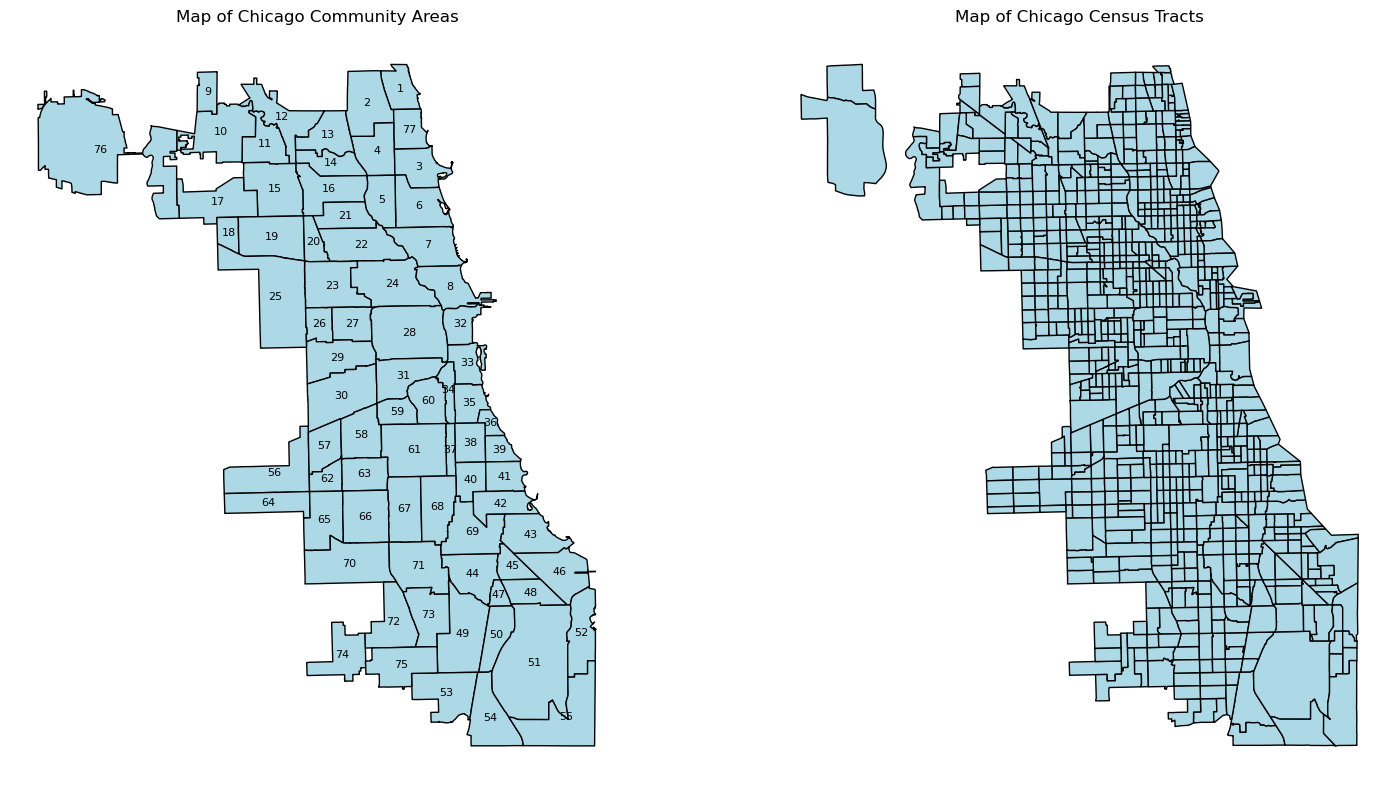

In [8]:
# Load the GeoJSON files
chicago_community_areas = gpd.read_file('../data/Boundaries_Community_Areas.geojson')
chicago_census_tracts = gpd.read_file('../data/Boundaries_Census_Tracts.geojson')

# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Map of Chicago Community Areas with Labels
chicago_community_areas.plot(ax=axs[0], color='lightblue', edgecolor='black')

# Add labels
for idx, row in chicago_community_areas.iterrows():
    axs[0].annotate(text=row['area_numbe'],
                    xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                    ha='center', va='center', fontsize=8, color='black')

axs[0].set_title('Map of Chicago Community Areas')

# Remove the axis
axs[0].axis('off')

# Plot 2: Map of Chicago Census Tracts
chicago_census_tracts.plot(ax=axs[1], color='lightblue', edgecolor='black')

axs[1].set_title('Map of Chicago Census Tracts')

# Remove the axis
axs[1].axis('off')

# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()

## Data for Choropleth Maps

In [9]:
def process_column(df, column_name):
  return df[column_name].value_counts().rename_axis(column_name).reset_index(name='trips').sort_values(by=column_name).reset_index(drop=True)

pickup_community_area_df = process_column(df, 'pickup_community_area')
dropoff_community_area_df = process_column(df, 'dropoff_community_area')
pickup_census_tract_df = process_column(df, 'pickup_census_tract')
dropoff_census_tract_df = process_column(df, 'dropoff_census_tract')

In [12]:
# per capita income
pci_df = pd.read_csv('../data/Census_Data.csv')
pci_df['Community Area Number'] = pci_df['Community Area Number'].fillna(0)
pci_df['Community Area Number'] = pci_df['Community Area Number'].astype(int)
pci_df['community_area_number'] = pci_df['Community Area Number']
pci_df['community_area_name'] = pci_df[pci_df.columns[1]]
pci_df['per_capita_income'] = pci_df[pci_df.columns[7]]
pci_df = pci_df[['community_area_number', 'community_area_name', 'per_capita_income']]
pci_df = pci_df.drop(pci_df.index[-1])
pci_df

,community_area_number,community_area_name,per_capita_income
0,1,Rogers Park,23939
1,2,West Ridge,23040
2,3,Uptown,35787
3,4,Lincoln Square,37524
4,5,North Center,57123
...,...,...,...
72,73,Washington Height,19713
73,74,Mount Greenwood,34381
74,75,Morgan Park,27149
75,76,O'Hare,25828


## Choropleth Map of Pick-Ups

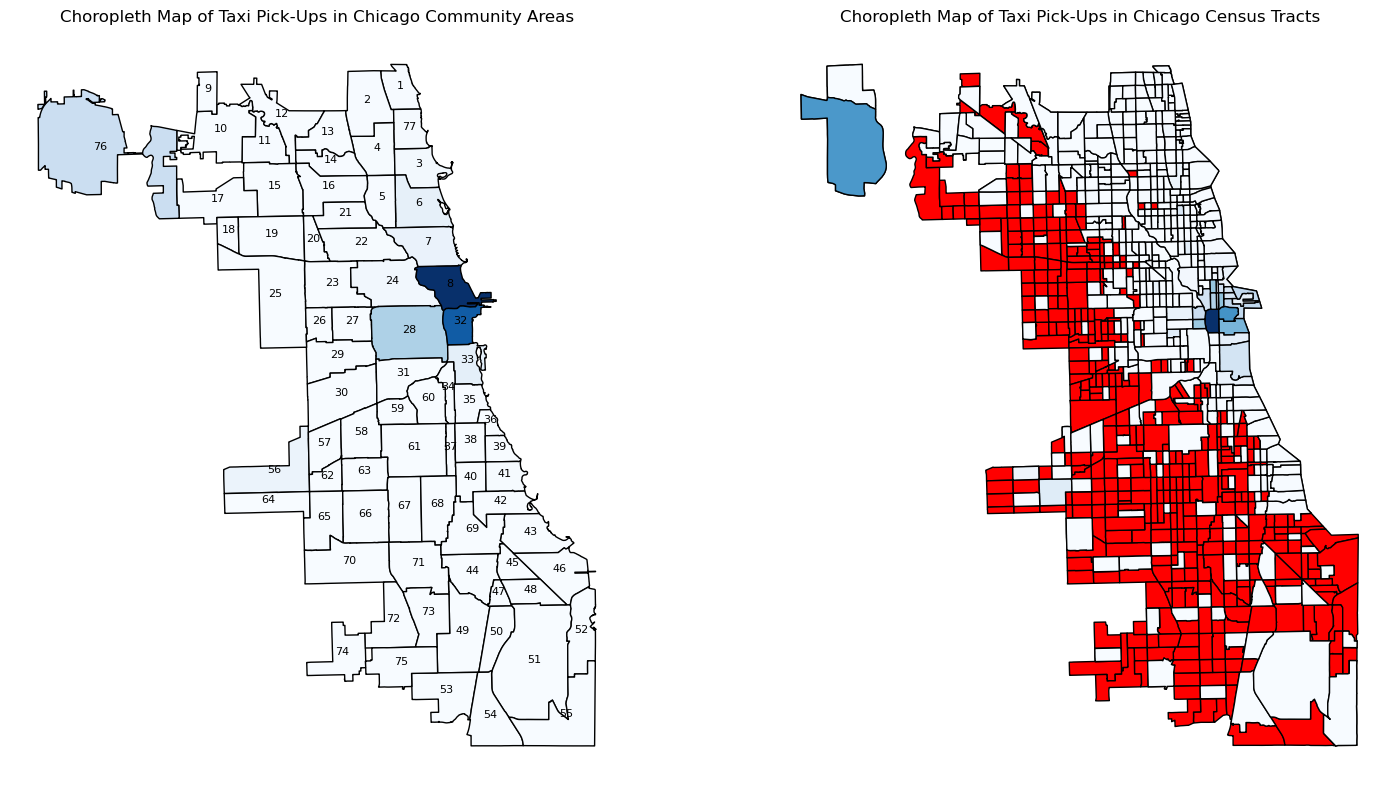

In [13]:
# Load the GeoJSON files and taxi trip data
chicago_community_areas_gdf = gpd.read_file('../data/Boundaries_Community_Areas.geojson')
chicago_community_areas_gdf['area_numbe'] = chicago_community_areas_gdf['area_numbe'].astype(int)
chicago_census_tracts_gdf = gpd.read_file('../data/Boundaries_Census_Tracts.geojson')
pickup_census_tract_df['pickup_census_tract'] = pickup_census_tract_df['pickup_census_tract'].astype(str)
chicago_census_tracts_gdf['geoid10'] = chicago_census_tracts_gdf['geoid10'].astype(str)

# Merge GeoDataFrame with the taxi trip data
plot1_gdf = chicago_community_areas_gdf.merge(pickup_community_area_df, left_on='area_numbe', right_on='pickup_community_area')
plot2_gdf = chicago_census_tracts_gdf.merge(pickup_census_tract_df, left_on='geoid10', right_on='pickup_census_tract')

# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Choropleth Map of Taxi Pickups in Chicago Community Areas
plot1_gdf.plot(column='trips', ax=axs[0], legend=False,
                        cmap='Blues', edgecolor='black')

# Add community area numbers to the map
for idx, row in plot1_gdf.iterrows():
    axs[0].annotate(text=row['area_numbe'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                    ha='center', fontsize=8, color='black')

# Set title and remove axis
axs[0].set_title('Choropleth Map of Taxi Pick-Ups in Chicago Community Areas')
axs[0].axis('off')

# Plot 2: Map of Chicago Census Tracts in Chicago Census Tracts
chicago_census_tracts.plot(ax=axs[1], color='red', edgecolor='black')

# Plot 2: Choropleth Map of Taxi Pickups in Chicago Census Tracts
plot2_gdf.plot(column='trips', ax=axs[1], legend=False,
                         cmap='Blues', edgecolor='black')

# Set title and remove axis
axs[1].set_title('Choropleth Map of Taxi Pick-Ups in Chicago Census Tracts')
axs[1].axis('off')

# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()

## Choropleth Map of Drop-Offs

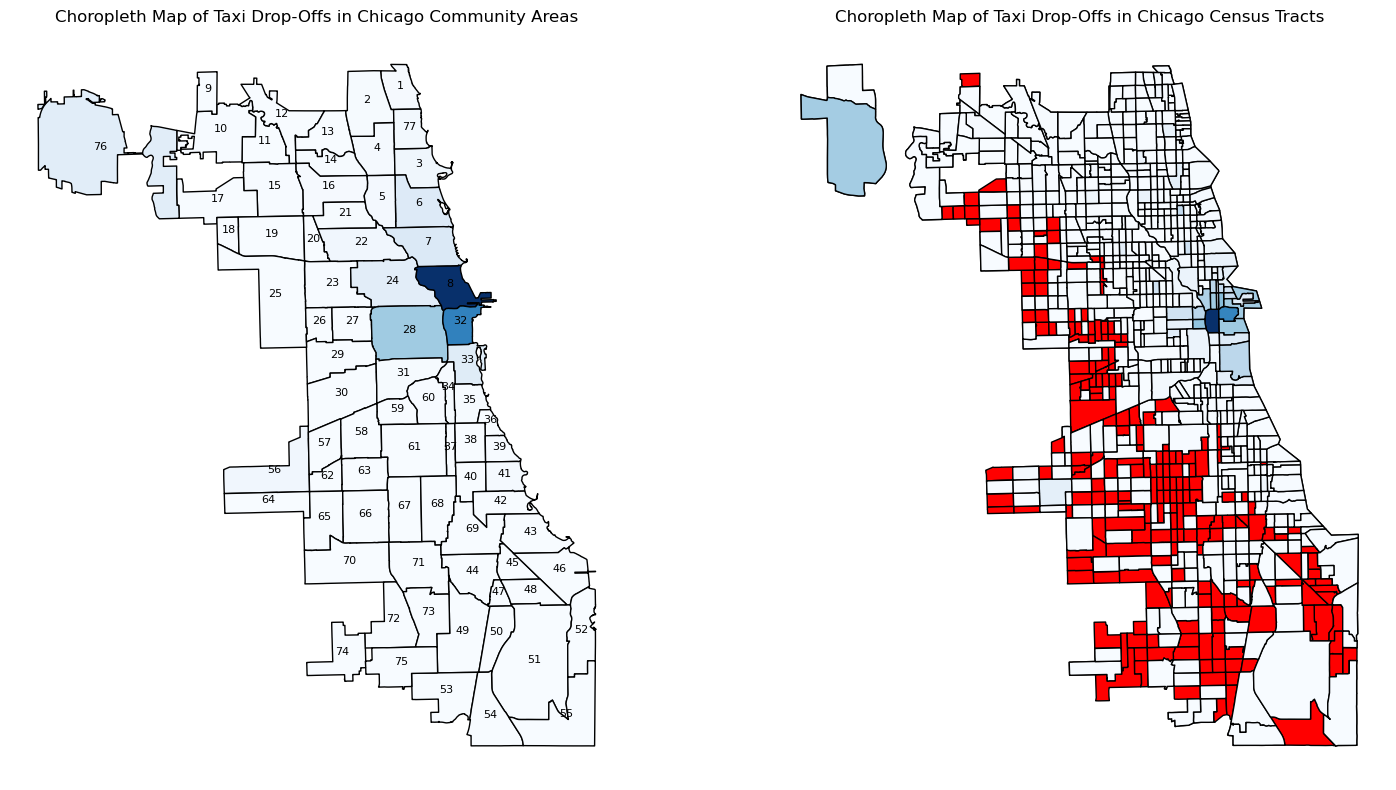

In [14]:
# Load the GeoJSON files and taxi trip data
chicago_community_areas_gdf = gpd.read_file('../data/Boundaries_Community_Areas.geojson')
chicago_community_areas_gdf['area_numbe'] = chicago_community_areas_gdf['area_numbe'].astype(int)
chicago_census_tracts_gdf = gpd.read_file('../data/Boundaries_Census_Tracts.geojson')
dropoff_census_tract_df['dropoff_census_tract'] = dropoff_census_tract_df['dropoff_census_tract'].astype(str)
chicago_census_tracts_gdf['geoid10'] = chicago_census_tracts_gdf['geoid10'].astype(str)

# Merge GeoDataFrame with the taxi trip data
plot3_gdf = chicago_community_areas_gdf.merge(dropoff_community_area_df, left_on='area_numbe', right_on='dropoff_community_area')
plot4_gdf = chicago_census_tracts_gdf.merge(dropoff_census_tract_df, left_on='geoid10', right_on='dropoff_census_tract')

# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot 3: Choropleth Map of Taxi Pickups in Chicago Community Areas
plot3_gdf.plot(column='trips', ax=axs[0], legend=False,
                        cmap='Blues', edgecolor='black')

# Add community area numbers to the map
for idx, row in plot3_gdf.iterrows():
    axs[0].annotate(text=row['area_numbe'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                   ha='center', fontsize=8, color='black')

# Set title and remove axis
axs[0].set_title('Choropleth Map of Taxi Drop-Offs in Chicago Community Areas')
axs[0].axis('off')

# Plot 4: Map of Chicago Census Tracts in Chicago Census Tracts
chicago_census_tracts.plot(ax=axs[1], color='red', edgecolor='black')

# Plot 4: Choropleth Map of Taxi Dropoffs in Chicago Census Tracts
plot4_gdf.plot(column='trips', ax=axs[1], legend=False,
                         cmap='Blues', edgecolor='black')

# Set title and remove axis
axs[1].set_title('Choropleth Map of Taxi Drop-Offs in Chicago Census Tracts')
axs[1].axis('off')

# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()

## Choropleth Map of Per Capita Income

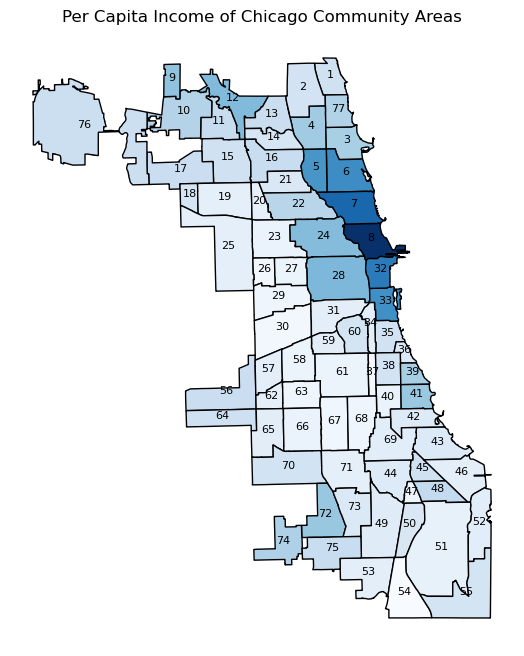

In [15]:
# Load the GeoJSON files
chicago_community_areas_gdf = gpd.read_file('../data/Boundaries_Community_Areas.geojson')
chicago_community_areas_gdf['area_numbe'] = chicago_community_areas_gdf['area_numbe'].astype(int)

pci_plot_gdf = chicago_community_areas_gdf.merge(pci_df, left_on='area_numbe', right_on='community_area_number')

# Create a single plot
fig, ax = plt.subplots(figsize=(8, 8))

# Plot 1: Choropleth Map of Taxi Pickups in Chicago Community Areas
pci_plot_gdf.plot(column='per_capita_income', ax=ax, legend=False,
                        cmap='Blues', edgecolor='black')

# Add community area numbers to the map
for idx, row in pci_plot_gdf.iterrows():
    ax.annotate(text=row['area_numbe'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                    ha='center', fontsize=8, color='black')

# Set the title
ax.set_title('Per Capita Income of Chicago Community Areas')

# Remove the axis
ax.axis('off')

# Show the plot
plt.show()

# Hexagon Choropleth Maps

In [16]:
def create_choropleth(dataframe,h3geocol,datacol,legend_name):
    grouped_data = dataframe.groupby(dataframe[h3geocol])[datacol].mean().reset_index()
    m = folium.Map(location=[41.8781, -87.6298], zoom_start=10)
    
    geojson_data = {
        'type': 'FeatureCollection',
        'features': []
    }
    
    for index, row in grouped_data.iterrows():
        geometry = {'type': 'Polygon', 'coordinates': [h3.h3_to_geo_boundary(row[h3geocol], geo_json=True)]}
        feature = {'type': 'Feature', 'geometry': geometry, 'properties': {f'{h3geocol}': row[h3geocol],f'{datacol}': row[datacol]}}
        geojson_data['features'].append(feature)
        
    cp = folium.Choropleth(
        geo_data=geojson_data,
        data=grouped_data,
        columns=[h3geocol, datacol],
        key_on=f'feature.properties.{h3geocol}',
        fill_color='YlGnBu',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=legend_name
    ).add_to(m)

    folium.GeoJsonTooltip([h3geocol,datacol]).add_to(cp.geojson)
    
    return m

def create_choropleth_size(dataframe, h3geocol, legend_name):
    # Count the number of rides per H3 hexagon
    grouped_data = dataframe.groupby(h3geocol).size().reset_index(name='total_rides')
    
    # Create a base map
    m = folium.Map(location=[41.8781, -87.6298], zoom_start=10)
    
    # Create GeoJSON data
    geojson_data = {
        'type': 'FeatureCollection',
        'features': []
    }
    
    # Generate GeoJSON features for each H3 hexagon
    for index, row in grouped_data.iterrows():
        geometry = {
            'type': 'Polygon',
            'coordinates': [h3.h3_to_geo_boundary(row[h3geocol], geo_json=True)]
        }
        feature = {
            'type': 'Feature',
            'geometry': geometry,
            'properties': {
                f'{h3geocol}': row[h3geocol],
                'total_rides': row['total_rides']
            }
        }
        geojson_data['features'].append(feature)
    
    # Create the choropleth map
    folium.Choropleth(
        geo_data=geojson_data,
        data=grouped_data,
        columns=[h3geocol, 'total_rides'],  # Ensure columns are correct
        key_on=f'feature.properties.{h3geocol}',
        fill_color='YlGnBu',
        fill_opacity=0.7,
        line_opacity=0,  # Remove outlines
        legend_name=legend_name
    ).add_to(m)
    
    # Add tooltips to display H3 ID and number of rides
    folium.GeoJsonTooltip(
        fields=[h3geocol, 'total_rides'],
        aliases=['H3 ID:', legend_name]
    ).add_to(folium.GeoJson(geojson_data).add_to(m))
    
    return m

## Choropleth of Total Trips

In [17]:
create_choropleth_size(df,"h3_res_8_pickup","Total trips")

## Choropleth of Average Trip Seconds

In [18]:
create_choropleth(df,"h3_res_8_pickup","trip_seconds","Average Total trip seconds")

## Choropleth of Average Price per Mile

In [19]:
create_choropleth(df,"h3_res_8_dropoff","price_per_mile","Average price per mile")

## Choropleth of Average Tips

In [20]:
create_choropleth(df,"h3_res_8_pickup","tips","Average tips")

# Heat Maps

In [21]:
tempdf = df.copy()

In [22]:
hourly = tempdf.groupby(df["trip_middle_timestamp"].dt.hour)["trip_seconds"].mean().reset_index()
weekdaily = tempdf.groupby(df["trip_middle_timestamp"].dt.weekday)["trip_seconds"].mean().reset_index()

In [23]:
# Neue Spalten für Stunde und Wochentag hinzufügen
tempdf['hour'] = df['trip_middle_timestamp'].dt.hour
tempdf['weekday'] = df['trip_middle_timestamp'].dt.day_name()

## Heat Map of Trips

<Axes: xlabel='hour', ylabel='weekday'>

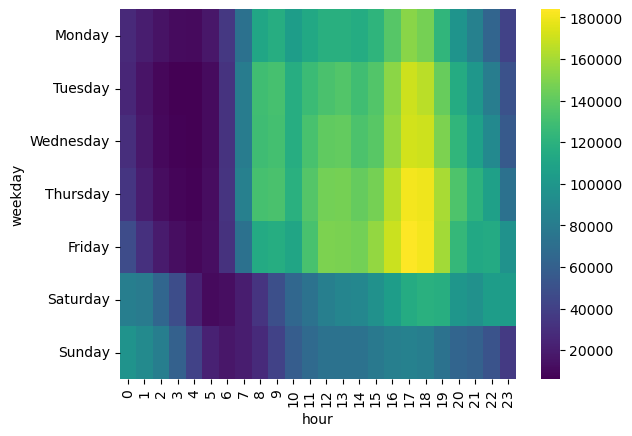

In [24]:
#NUMBER OF RIDES PER HOUR
pivot_table_trip_count = tempdf.pivot_table(index='weekday', columns='hour', values='trip_seconds', aggfunc='size')
pivot_table_trip_count = pivot_table_trip_count.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot the heatmap
sns.heatmap(pivot_table_trip_count, cmap='viridis')

## Heat Map of Trip Seconds

<Axes: xlabel='hour', ylabel='weekday'>

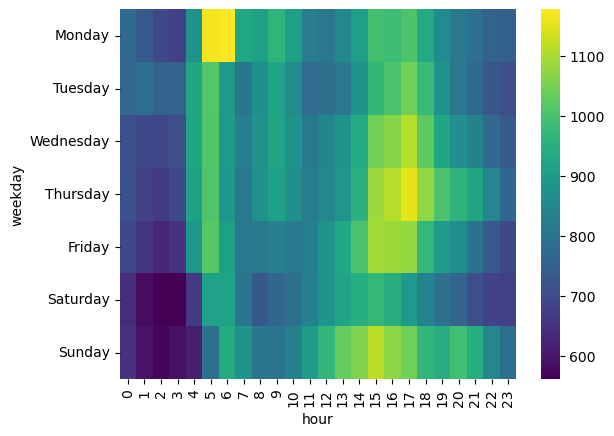

In [25]:
pivot_table_trip_seconds = tempdf.pivot_table(index='weekday', columns='hour', values='trip_seconds', aggfunc='mean')
pivot_table_trip_seconds = pivot_table_trip_seconds.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
sns.heatmap(pivot_table_trip_seconds, cmap='viridis') #trip seconds

## Heat Map of Tips

<Axes: xlabel='hour', ylabel='weekday'>

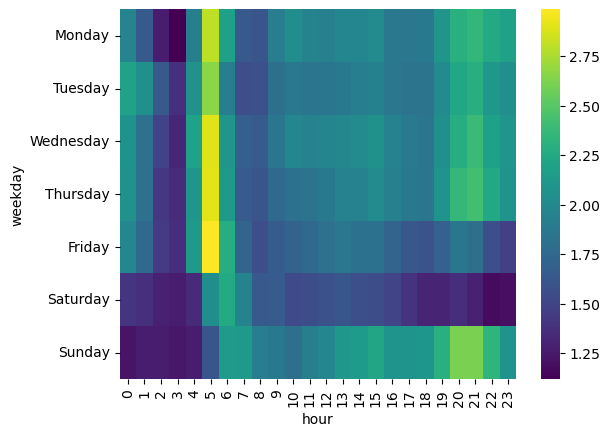

In [26]:
pivot_table_count = tempdf.pivot_table(index='weekday', columns='hour',values="tips",aggfunc='mean')
pivot_table_count = pivot_table_count.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
sns.heatmap(pivot_table_count, cmap='viridis') #tip count

# Idle Time

In [27]:
df_sorted = df.sort_values(by=['taxi_id', 'trip_start_timestamp'])
df_sorted['idle_time'] = df_sorted.groupby('taxi_id')['trip_start_timestamp'].shift(-1) - df_sorted['trip_end_timestamp']
idledf = df_sorted.groupby('taxi_id')['idle_time'].mean().reset_index()
idledf

,taxi_id,idle_time
0,001330b81e23412049f9c3eff5b6e972a91afe59c9aa36...,0 days 01:43:19.010568922
1,0013da5489fe976daf4f4a7d246073ecf2caed9b12b3be...,0 days 02:11:58.058628318
2,0044e6c0d091476299b99345501f756b23632a96cbaf40...,0 days 03:12:16.789431545
3,00752524a4118a162dce62ff49c0eb0f79530d9e0ecb5a...,0 days 03:35:22.656597067
4,0083fcde0fb490b4ec424c63d1d750378f6ad11154d1d4...,0 days 14:48:08.372093023
...,...,...
5706,ffd70d111c7da2e5eff27ad900c8eb94d74fe286bb7aa5...,0 days 02:49:41.571428571
5707,ffda53354c610fd3af1aee46d723028a49014e35f7280c...,0 days 01:48:54.701834862
5708,ffe8d8153b8f68cd20871ae5710f9b799bcc517b40ece7...,0 days 02:19:10.400000
5709,fff3279af11dfade5e308184a5cc6c1ca2d33764634d96...,0 days 03:12:44.963205233


I discontinued this analysis, because i figured that taxi_id represents a unique vehicle rather than a unique taxi driver. Thus, there could be multiple drivers operating one taxi over the course of the year.

# Correlation grouped by hour

In [28]:
corrdf = df.copy()

In [29]:
corrdf['date_hour'] = corrdf['trip_middle_timestamp'].dt.floor('h')
hourly_rides = corrdf.groupby('date_hour').size().reset_index(name='num_rides')
hourly_precipitation = corrdf.groupby('date_hour')['precipitation'].mean().reset_index()
hourly_temperature = corrdf.groupby('date_hour')['temperature'].mean().reset_index()
hourly_price_per_mile = corrdf.groupby('date_hour')['price_per_mile'].mean().reset_index()
hourly_trip_total = corrdf.groupby('date_hour')['trip_total'].mean().reset_index()
# Merge the DataFrames
hourly_data = pd.merge(hourly_rides, hourly_precipitation, on='date_hour')
hourly_data = pd.merge(hourly_data, hourly_temperature, on='date_hour')
hourly_data = pd.merge(hourly_data, hourly_price_per_mile, on='date_hour')
hourly_data = pd.merge(hourly_data, hourly_trip_total, on='date_hour')
hourly_data['hour'] = hourly_data['date_hour'].dt.hour
hourly_data["weekend"] = pd.DatetimeIndex(hourly_data['date_hour']).dayofweek >= 5

## Bar Plot of Average Trips per Hour (depending on Precipitation)

Text(0.5, 1.0, 'Number of Taxi Rides with Precipitation > 0 vs. Precipitation = 0')

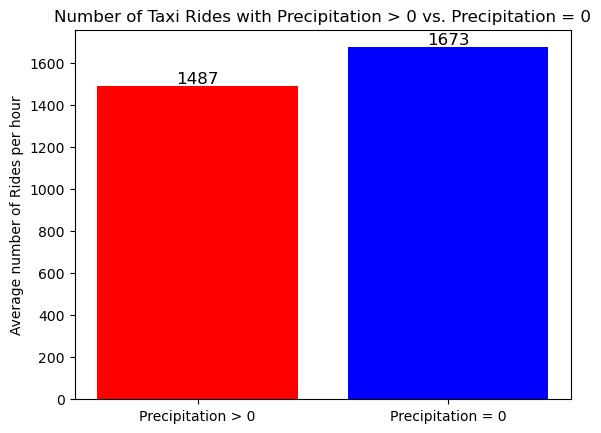

In [30]:
rides_precip_nonzero = hourly_data[hourly_data["precipitation"] > 0]["num_rides"].mean()
rides_precip_zero = hourly_data[hourly_data["precipitation"] == 0]["num_rides"].mean()

plot_data = pd.DataFrame({
    'Condition': ['Precipitation > 0', 'Precipitation = 0'],
    'Number of Rides': [rides_precip_nonzero, rides_precip_zero]
})

bar_plot = plt.bar(plot_data['Condition'], plot_data['Number of Rides'], color=['red', 'blue'])

for bar in bar_plot:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=12)

plt.ylabel('Average number of Rides per hour')
plt.title('Number of Taxi Rides with Precipitation > 0 vs. Precipitation = 0')

It should be noted that it rains a lot more at night where less rides occur. This plot shows that:

## Line Plot of Average Percipitation per Hour

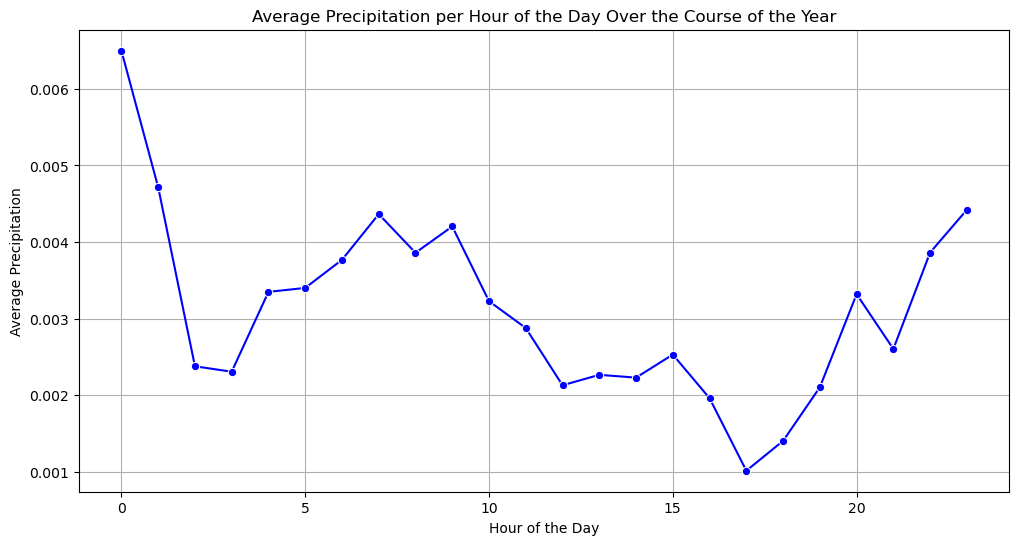

In [31]:
hourly_precipitation = hourly_data.groupby('hour')['precipitation'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='precipitation', data=hourly_precipitation, marker='o', color='blue')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Precipitation')
plt.title('Average Precipitation per Hour of the Day Over the Course of the Year')
plt.grid(True)

Thus, I created a plot that also incorporates the usual average per hour as a baseline:

## Line Plot of Average Number of Trips per Hour (depending on Percipitation)

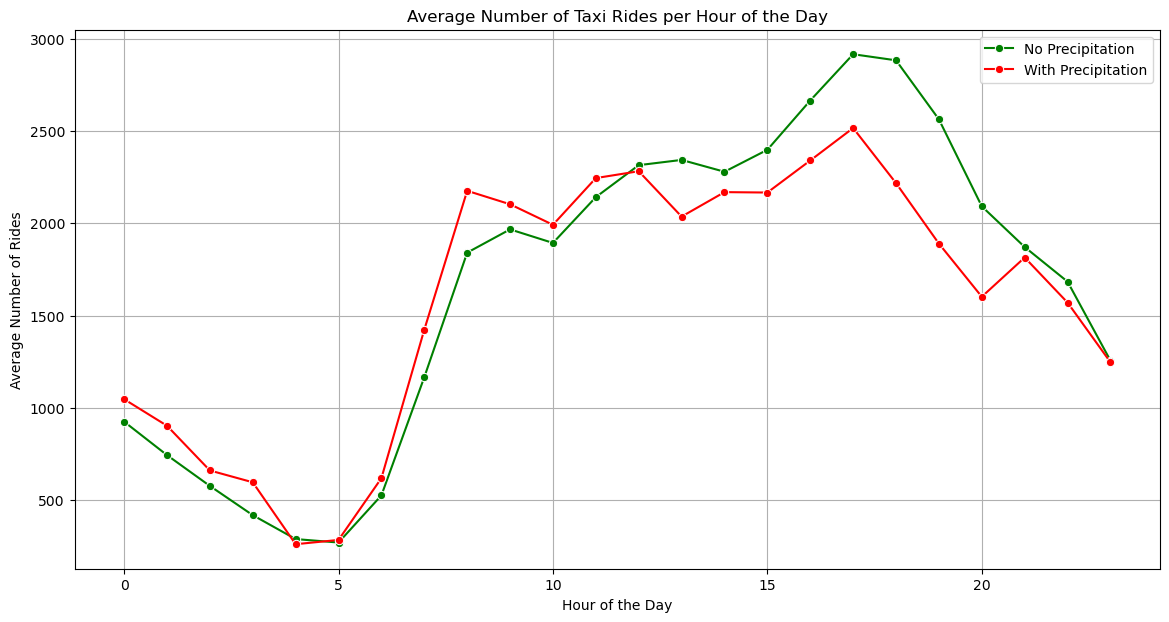

In [32]:
hourly_num_rides_no_rain = hourly_data[hourly_data["precipitation"]==0].groupby('hour')['num_rides'].mean().reset_index()
hourly_num_rides_rain = hourly_data[hourly_data["precipitation"]>0].groupby('hour')['num_rides'].mean().reset_index()
plt.figure(figsize=(14, 7))
sns.lineplot(x='hour', y='num_rides', data=hourly_num_rides_no_rain, label='No Precipitation', marker='o', color='green')
sns.lineplot(x='hour', y='num_rides', data=hourly_num_rides_rain, label='With Precipitation', marker='o', color='red')

plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Rides')
plt.title('Average Number of Taxi Rides per Hour of the Day')
plt.legend()
plt.grid(True)

It seems like rain could have a positive effects on rides at night, but a negative effect during the day. Effects could be marginal.

## Number of rides vs temperature

In [33]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
# Extract temperature and number of rides
X = hourly_data['temperature'].values.reshape(-1, 1)
y = hourly_data['num_rides'].values

# Create polynomial features
poly = PolynomialFeatures(degree=3)  
X_poly = poly.fit_transform(X)

# Fit the polynomial regression model
model = LinearRegression()
model.fit(X_poly, y)

# Predict values
y_poly_pred = model.predict(X_poly)

# Add predictions to the DataFrame for plotting
hourly_data['num_rides_poly_pred'] = y_poly_pred

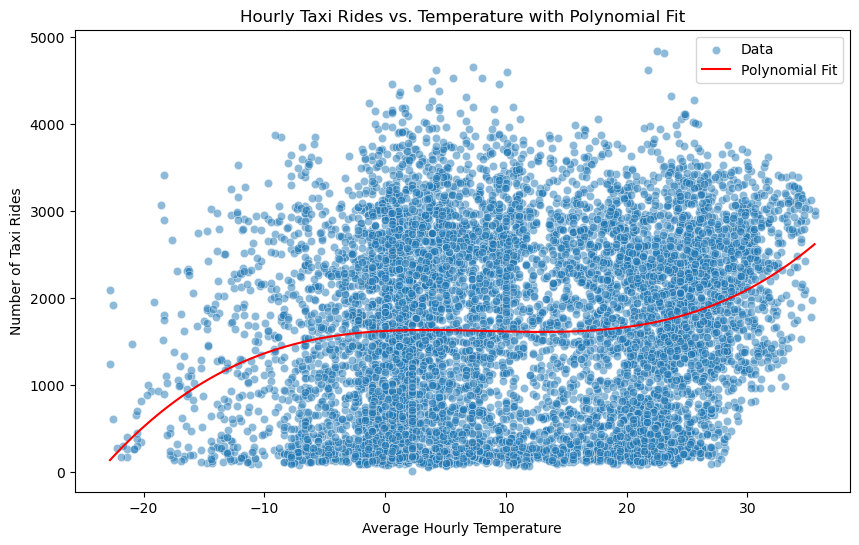

In [34]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='temperature', y='num_rides', data=hourly_data, alpha=0.5, label='Data')

# Sort the data for plotting the line
sorted_data = hourly_data.sort_values('temperature')
plt.plot(sorted_data['temperature'], sorted_data['num_rides_poly_pred'], color='red', label='Polynomial Fit')

plt.title('Hourly Taxi Rides vs. Temperature with Polynomial Fit')
plt.xlabel('Average Hourly Temperature')
plt.ylabel('Number of Taxi Rides')
plt.legend()
plt.show()

## Number of rides vs price per mile

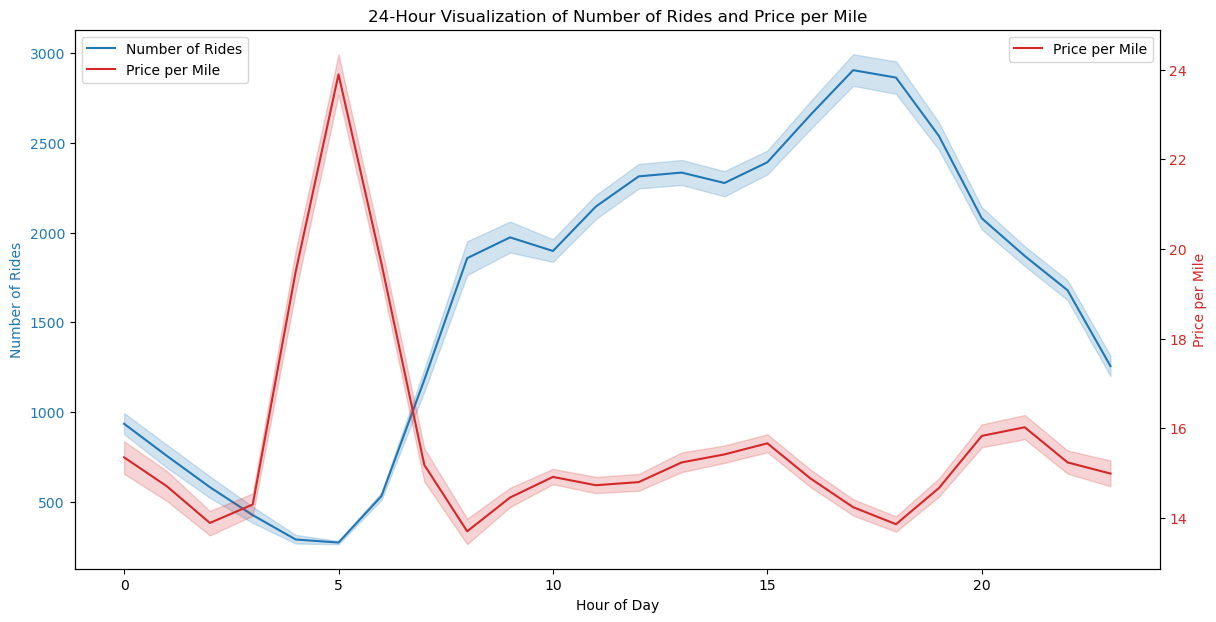

In [35]:
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot number of rides
color = 'tab:blue'
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Number of Rides', color=color)
line1 = sns.lineplot(x='hour', y='num_rides', data=hourly_data, ax=ax1, color=color, label='Number of Rides')
ax1.tick_params(axis='y', labelcolor=color)

# Plot price per mile
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Price per Mile', color=color)
line2 = sns.lineplot(x='hour', y='price_per_mile', data=hourly_data, ax=ax2, color=color, label='Price per Mile')
ax2.tick_params(axis='y', labelcolor=color)

# Add title and show plot
plt.title('24-Hour Visualization of Number of Rides and Price per Mile')

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()


## Trip seconds vs tips

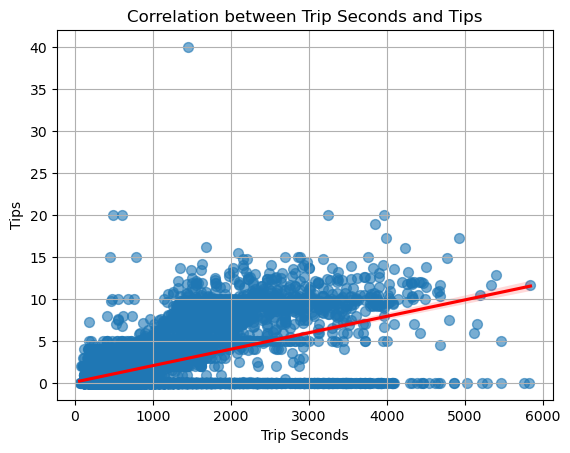

In [36]:
sns.regplot(x='trip_seconds', y='tips', data=df.sample(10000), scatter_kws={'s':50, 'alpha':0.6}, line_kws={'color':'red'})
plt.title('Correlation between Trip Seconds and Tips')
plt.xlabel('Trip Seconds')
plt.ylabel('Tips')
plt.grid(True)

# Temporal Analysis

## Number of rides over the course of the year

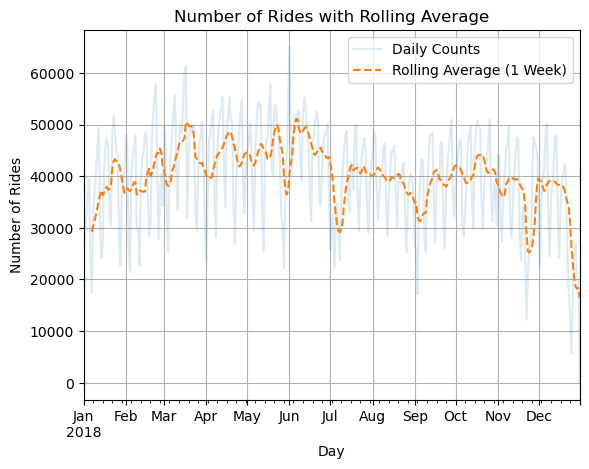

In [37]:
temp = df['trip_middle_timestamp'].dt.to_period('D')
daily_counts = temp.value_counts().sort_index()
daily_counts_rolling = daily_counts.rolling(window=7).mean()

daily_counts.plot(label='Daily Counts', alpha=0.15)
daily_counts_rolling.plot(label='Rolling Average (1 Week)', linestyle='--')
plt.title('Number of Rides with Rolling Average')
plt.xlabel('Day')
plt.ylabel('Number of Rides')
plt.legend()
plt.grid(True)

## Trip duration over the course of the year

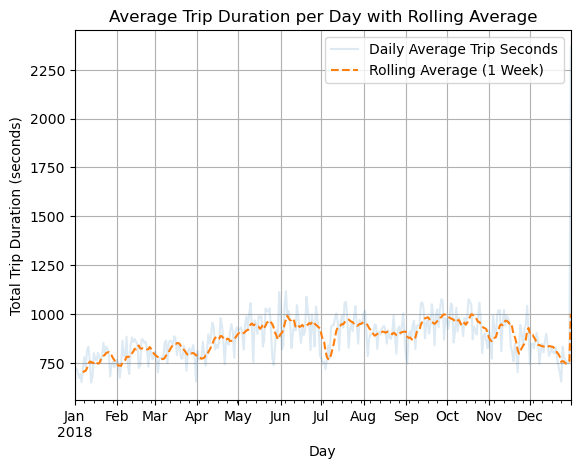

In [38]:
daily_trip_seconds = df.groupby(df['trip_middle_timestamp'].dt.to_period('D'))['trip_seconds'].mean().sort_index()
daily_trip_seconds_rolling = daily_trip_seconds.rolling(window=7).mean()

daily_trip_seconds.plot(label='Daily Average Trip Seconds', alpha=0.15)
daily_trip_seconds_rolling.plot(label='Rolling Average (1 Week)', linestyle='--')
plt.title('Average Trip Duration per Day with Rolling Average')
plt.xlabel('Day')
plt.ylabel('Total Trip Duration (seconds)')
plt.legend()
plt.grid(True)

# Payment Analysis

In [39]:
payment_counts = df['payment_type'].value_counts().reset_index()
payment_counts.columns = ['payment_type', 'count']

## Bar Plot of Payment Types

C:\Users\Lukas\AppData\Local\Temp\ipykernel_1852\366437917.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='payment_type', y='count', data=payment_counts, palette='viridis')


Text(0.5, 1.0, 'Number of Rides per Payment Type')

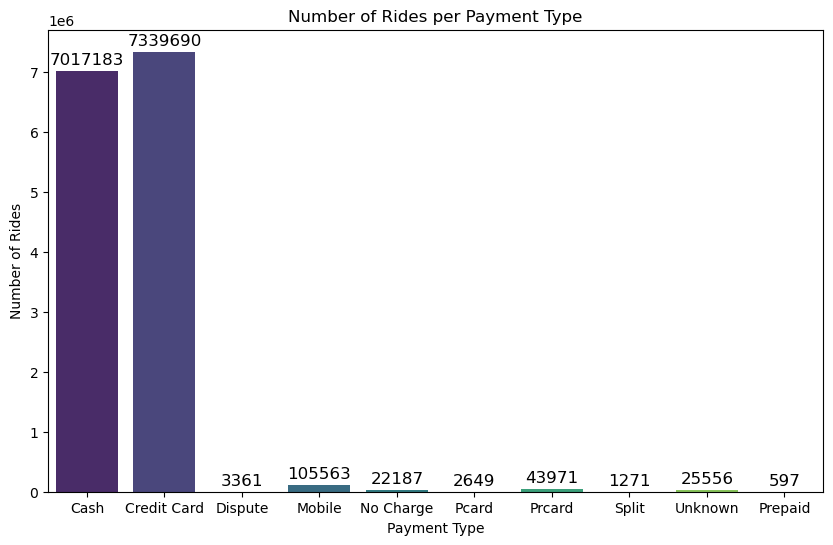

In [40]:
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='payment_type', y='count', data=payment_counts, palette='viridis')

# Add annotations without decimal places
for bar in barplot.patches:
    height = bar.get_height()
    barplot.annotate(f'{int(height)}', 
                     (bar.get_x() + bar.get_width() / 2, 
                      height), ha='center', va='center',
                     size=12, xytext=(0, 8),
                     textcoords='offset points')

plt.xlabel('Payment Type')
plt.ylabel('Number of Rides')
plt.title('Number of Rides per Payment Type')

## Line Plot of Payment Types per Hour (in %)

C:\Users\Lukas\AppData\Local\Temp\ipykernel_1852\1553735075.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hourly_payment_counts = df.groupby(['hour', 'payment_type']).size().reset_index(name='count')


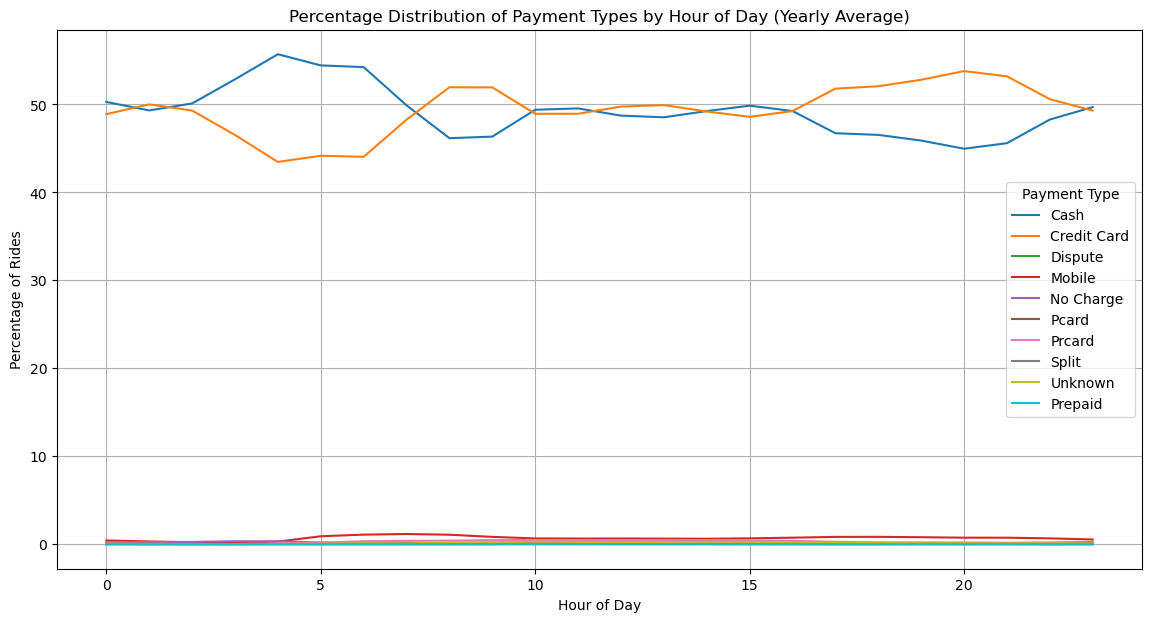

In [41]:
df['hour'] = df['trip_middle_timestamp'].dt.hour
hourly_payment_counts = df.groupby(['hour', 'payment_type']).size().reset_index(name='count')
total_counts_per_hour = hourly_payment_counts.groupby('hour')['count'].sum().reset_index(name='total_count')
hourly_payment_counts = pd.merge(hourly_payment_counts, total_counts_per_hour, on='hour')
hourly_payment_counts['percentage'] = (hourly_payment_counts['count'] / hourly_payment_counts['total_count']) * 100
pivot_data = hourly_payment_counts.pivot(index='hour', columns='payment_type', values='percentage').fillna(0)
pivot_data = pivot_data.reset_index()

plt.figure(figsize=(14, 7))

for payment_type in pivot_data.columns[1:]:
    plt.plot(pivot_data['hour'], pivot_data[payment_type], label=payment_type)

plt.xlabel('Hour of Day')
plt.ylabel('Percentage of Rides')
plt.title('Percentage Distribution of Payment Types by Hour of Day (Yearly Average)')
plt.legend(title='Payment Type')
plt.grid(True)

## Histogram of Total Cost by Payment Type

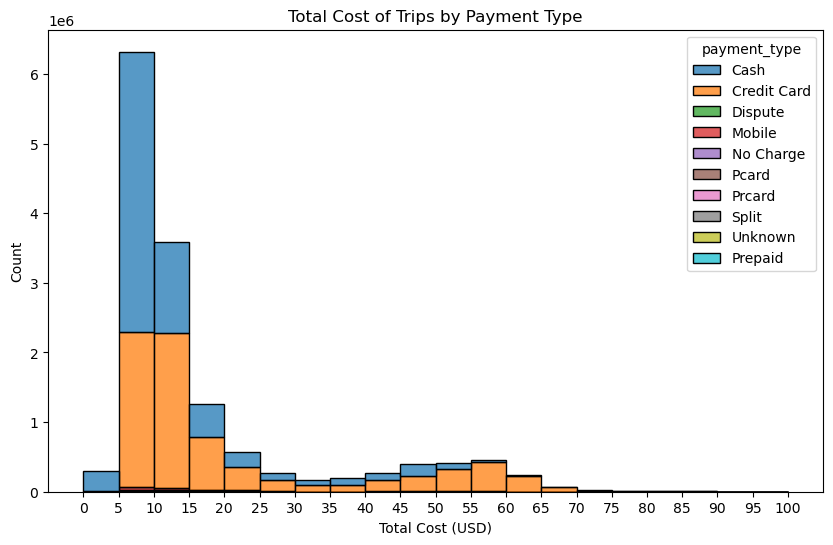

In [42]:
# Define the bin edges
bins = range(0, 105, 5)

# Plot the histogram with the specified bins using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='trip_total', hue='payment_type', multiple='stack', bins=bins)
plt.xlabel('Total Cost (USD)')
#plt.ylabel('Frequency')
plt.title('Total Cost of Trips by Payment Type')
plt.xticks(bins)  # Set x-axis ticks to bin edges
plt.show()